## Overview

The goal of this notebook is to gather data from the National Transit Database (NTD) and parse it into something usable for our transit carbon calculations. There are two datasets we need to import and parse, one being [NTD Annual Data - Fuel and Energy](https://data.transportation.gov/Public-Transit/2022-NTD-Annual-Data-Fuel-and-Energy/8ehq-7his/data) set, and the other being [NTD Service](https://www.transit.dot.gov/ntd/data-product/2022-service).

#### To Maintain

To update the data each year, update `urls` below with the most recent download links.

In [1]:
ntd_urls = {
  2022: {
    # https://www.transit.dot.gov/ntd/data-product/2022-fuel-and-energy
    "fuel_energy_csv": "https://data.transportation.gov/api/views/8ehq-7his/rows.csv?date=20231027&accessType=DOWNLOAD&bom=true&format=true",
    # https://www.transit.dot.gov/ntd/data-product/2022-service
    "service_csv": "https://data.transportation.gov/api/views/4fir-qbim/rows.csv?date=20231102&accessType=DOWNLOAD&bom=true&format=true",
    # https://www.transit.dot.gov/ntd/data-product/2022-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-07/2022%20Agency%20Information_1-3_0.xlsx",
  },
  2021: {
    # https://www.transit.dot.gov/ntd/data-product/2021-fuel-and-energy
    "fuel_energy_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2023-12/2021%20Fuel%20and%20Energy_1-1_0.xlsx",
    # https://www.transit.dot.gov/ntd/data-product/2021-service
    "service_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2022-10/2021%20Service_static.xlsx",
    # https://www.transit.dot.gov/ntd/data-product/2021-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2022-10/2021%20Agency%20Information.xlsx",
  },
  2020: {
    # https://www.transit.dot.gov/ntd/data-product/2020-fuel-and-energy
    "fuel_energy_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2023-12/2020-Fuel%20and%20Energy_1-1_1.xlsx",
    # https://www.transit.dot.gov/ntd/data-product/2020-service
    "service_zip": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2020-Service.zip",
    # https://www.transit.dot.gov/ntd/data-product/2020-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-11/2020%20Agency%20Information.xlsx",
  },
  2019: {
    # https://www.transit.dot.gov/ntd/data-product/2019-fuel-and-energy
    "fuel_energy_zip": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Fuel%20and%20Energy.zip",
    # https://www.transit.dot.gov/ntd/data-product/2019-service
    "service_zip": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Service.zip",
    # https://www.transit.dot.gov/ntd/data-product/2019-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-05/2019%20Agency%20Info.xlsx",
  },
  2018: {
    # https://www.transit.dot.gov/ntd/data-product/2018-fuel-and-energy
    "fuel_energy_xlsm": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Fuel%20and%20Energy_3.xlsm",
    # https://www.transit.dot.gov/ntd/data-product/2018-service
    "service_xlsm": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Service_4.xlsm",
    # https://www.transit.dot.gov/ntd/data-product/2018-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2018%20Agency%20Info_1.xlsx",
  }
}

# XLSX detailing urbanized areas; establishes relationship UACE Codes and UZA codes (which were used by NTD pre-2022)
census_changes_xlsx = "https://www.transit.dot.gov/sites/fta.dot.gov/files/2023-10/UZA_CHANGES_1990-2020_2_5.xlsx"

# CSV with relationship between ZCTA codes and UACE codes (from us_geo on GitHub)
zcta_urban_areas_urls = {
  2020: "https://raw.githubusercontent.com/bdurand/us_geo/master/data/dist/zcta_urban_areas.csv",
  2010: "https://raw.githubusercontent.com/bdurand/us_geo/master/data/2020_dist/zcta_urban_areas.csv"
}
# CSV with relationship between ZCTA codes and UZA codes (from acs-aggregate on GitHub)
zip_to_zcta_url = "https://raw.githubusercontent.com/censusreporter/acs-aggregate/master/crosswalks/zip_to_zcta/zip_zcta_xref.csv"

In [2]:
# imports

# execute this notebook from the 'src' directory so we can import 'emcommon' code
%cd ../src

import pandas as pd
import matplotlib.pyplot as plt
import json
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen
import re

import emcommon.metrics.footprint.util as emcmfu

/Users/jgreenle/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/jgreenle/openpath/e-mission-common/src


In [3]:
# create UZA to UACE mapping using the NTD's census_changes_xlsx

census_changes_df = pd.read_excel(census_changes_xlsx)
census_changes_df = census_changes_df[["2010 NTD UZA Code (Deprecated)", "2020 UACE"]].dropna().astype(int)
# pad to 5 digits
census_changes_df['2020 UACE'] = census_changes_df['2020 UACE'].apply(lambda x: str(x).zfill(5))
uza_to_uace = census_changes_df.set_index("2010 NTD UZA Code (Deprecated)")["2020 UACE"].to_dict()
print("uza_to_uace: " + json.dumps(uza_to_uace, indent=2))

uza_to_uace: {
  "1": "63217",
  "2": "51445",
  "3": "16264",
  "4": "56602",
  "7": "40429",
  "6": "22042",
  "5": "69076",
  "8": "92242",
  "9": "03817",
  "10": "09271",
  "12": "69184",
  "11": "23824",
  "14": "80389",
  "13": "78904",
  "15": "78661",
  "16": "57628",
  "17": "86599",
  "18": "23527",
  "22": "75340",
  "19": "04843",
  "23": "47995",
  "20": "77770",
  "24": "71317",
  "26": "78580",
  "28": "77068",
  "32": "65863",
  "21": "79093",
  "29": "79039",
  "37": "04384",
  "27": "69697",
  "25": "17668",
  "33": "41212",
  "30": "16885",
  "31": "43912",
  "36": "19234",
  "34": "90892",
  "38": "15670",
  "35": "57466",
  "39": "72505",
  "40": "42346",
  "42": "78499",
  "44": "61273",
  "50": "73261",
  "45": "74746",
  "41": "56116",
  "51": "65080",
  "47": "37243",
  "43": "51755",
  "49": "62677",
  "46": "11350",
  "48": "10162",
  "52": "88732",
  "53": "27253",
  "54": "39889",
  "58": "65269",
  "57": "52390",
  "64": "09536",
  "55": "07786",
  "56": 

In [4]:
# ZIP postcodes to ZCTA codes
zip_to_zcta_df = pd.read_csv(zip_to_zcta_url)

# create ZCTA to UACE dfs using the zcta_to_uace_2010_csv and zcta_to_uace_2020_csv
zcta_urban_areas_dfs = { y: pd.read_csv(zcta_urban_areas_urls[y]) for y in zcta_urban_areas_urls }
# merge zip_to_zcta_df with zcta_urban_areas_dfs to get ZIP to UACE mappings
zip_uace_dfs = {
  y: zcta_urban_areas_dfs[y].merge(zip_to_zcta_df, left_on="ZCTA5", right_on="zcta")
  for y in zcta_urban_areas_dfs
}
# pad both zip_code and UACE to 5 digits
zip_uace_dfs = {
  y: zip_uace_dfs[y][["zip_code", "Urban Area GEOID"]].apply(lambda x: x.astype(str).str.zfill(5))
  for y in zcta_urban_areas_dfs
}
# store as dictionary {year: {UACE: [ZIPs]}}
uace_zip_maps = {
  y: zip_uace_dfs[y].groupby("Urban Area GEOID")["zip_code"].apply(list).to_dict()
  for y in zip_uace_dfs
}

print("uace_zip_maps: " + json.dumps(uace_zip_maps, indent=2))

uace_zip_maps: {
  "2020": {
    "00037": [
      "70510",
      "70511",
      "70528",
      "70533",
      "70560",
      "70562",
      "70569",
      "70575"
    ],
    "00064": [
      "29620"
    ],
    "00091": [
      "54405",
      "54421"
    ],
    "00118": [
      "38825",
      "39730"
    ],
    "00145": [
      "57401"
    ],
    "00172": [
      "98520",
      "98537",
      "98550",
      "98563"
    ],
    "00199": [
      "21001",
      "21005",
      "21009",
      "21013",
      "21014",
      "21015",
      "21017",
      "21040",
      "21018",
      "21047",
      "21050",
      "21078",
      "21084",
      "21085",
      "21087",
      "21111",
      "21130",
      "21156",
      "21902",
      "21903",
      "21904",
      "21917",
      "21918"
    ],
    "00226": [
      "79311"
    ],
    "00253": [
      "67410"
    ],
    "00280": [
      "79563",
      "79601",
      "79698",
      "79602",
      "79604",
      "79608",
      "79697",
      "79603",
  

In [5]:
def fuel_energy_df_without_outliers(df, fuel_types):
    # replace zero values with NA so they will be ignored
    df = df.replace(0, pd.NA)

    # plot distribution of Wh/km for each fuel type
    for fuel_type in fuel_types:
        plt.hist(df[fuel_type + ' (Wh/km)'].dropna(),
                 bins=100, alpha=0.5,
                 label=fuel_type)
    plt.xlabel('Wh/km')
    plt.ylabel('Frequency')
    plt.title('Distribution of Wh/km for all fuel types')
    plt.legend()
    plt.show()

    print(f"Len before trimming: {len(df)}")
    # trim outliers
    for fuel_type in fuel_types:
        col_name = fuel_type + ' (Wh/km)'
        wh_km_col = df[col_name].dropna().astype(float)
        print(f"{fuel_type} description: {wh_km_col.describe()}")
        pctile_10 = wh_km_col.quantile(0.1)
        pctile_90 = wh_km_col.quantile(0.9)
        print(f"{fuel_type}, trimming to [{pctile_10}, {pctile_90}]")
        # for outliers, set all columns of that fuel type to NA
        df.loc[
            (df[col_name] < pctile_10) | (df[col_name] > pctile_90),
            [fuel_type + ' (Wh/km)', fuel_type + ' (km)', fuel_type + ' (kWh)']
        ] = pd.NA
    # drop rows where all fuel types are now NA
    df = df.dropna(subset=[f + ' (Wh/km)' for f in fuel_types], how='all')
    print(f"Len after trimming: {len(df)}")

    # plot again after trimming
    for fuel_type in fuel_types:
        plt.hist(df[fuel_type + ' (Wh/km)'].dropna(),
                 bins=100,
                 alpha=0.5,
                 label=fuel_type)
    plt.xlabel('Wh/km')
    plt.ylabel('Frequency')
    plt.title('Distribution of Wh/km across fuel types after trimming outliers')
    plt.legend()
    plt.show()

    return df

/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


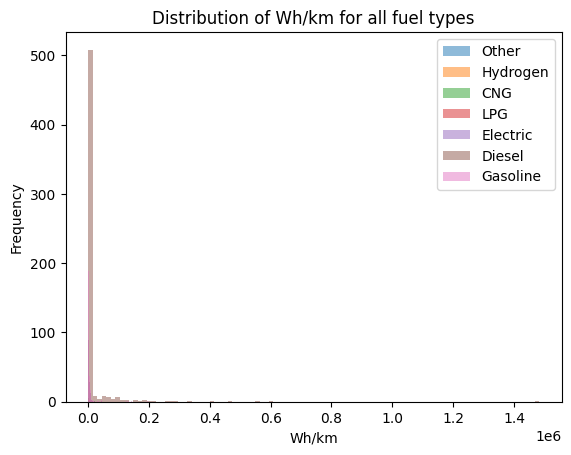

Len before trimming: 1152
Other description: count        3.000000
mean      8235.013466
std       6933.026744
min       3608.059045
25%       4249.391273
50%       4890.723500
75%      10548.490676
max      16206.257853
Name: Other (Wh/km), dtype: float64
Other, trimming to [3864.5919358964975, 13943.150982080326]
Hydrogen description: count       7.000000
mean     3191.627928
std      1641.827685
min       180.327332
25%      2497.589648
50%      3610.776303
75%      4340.970036
max      4873.172495
Name: Hydrogen (Wh/km), dtype: float64
Hydrogen, trimming to [1502.2900807871283, 4845.033240838147]
CNG description: count     193.000000
mean     1375.407924
std       724.972716
min         5.961097
25%       924.769917
50%      1357.528151
75%      1666.296664
max      7996.539906
Name: CNG (Wh/km), dtype: float64
CNG, trimming to [642.5051270744492, 2018.5242681847853]
LPG description: count      38.000000
mean     3391.125746
std      1492.592399
min        80.834574
25%      2937.4

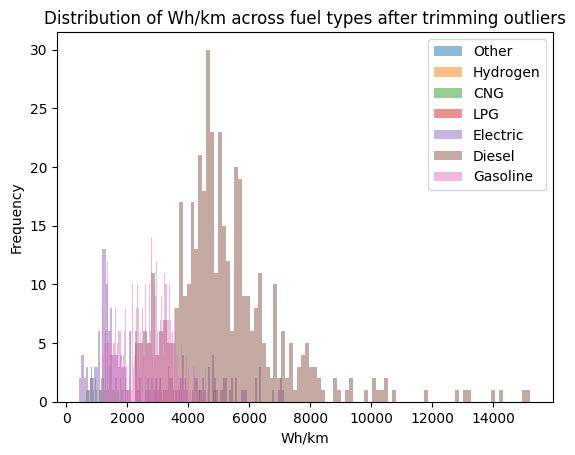

/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:130: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['All Fuels (km)'] = sum([df[f + ' (km)'].fillna(0) for f in new_fuel_types])
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors

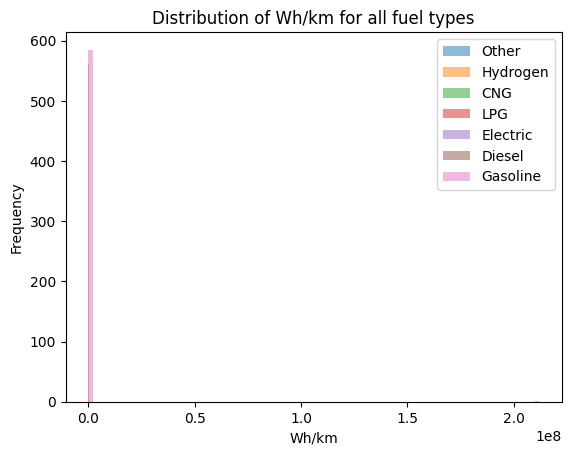

Len before trimming: 1141
Other description: count        5.000000
mean     22593.400919
std      26995.785243
min         11.753502
25%       8705.781366
50%      16918.448963
75%      18248.781319
max      69082.239444
Name: Other (Wh/km), dtype: float64
Other, trimming to [3489.3646476339272, 48748.85619410232]
Hydrogen description: count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Hydrogen (Wh/km), dtype: float64
Hydrogen, trimming to [nan, nan]
CNG description: count      195.000000
mean      1503.030177
std       1436.018692
min         57.587875
25%        939.860914
50%       1394.031258
75%       1635.223912
max      14470.219247
Name: CNG (Wh/km), dtype: float64
CNG, trimming to [596.5250910501871, 1988.2991122563858]
LPG description: count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: LPG (Wh/km), dtype: float64
LPG, trimming to [nan, nan]
Electric descriptio

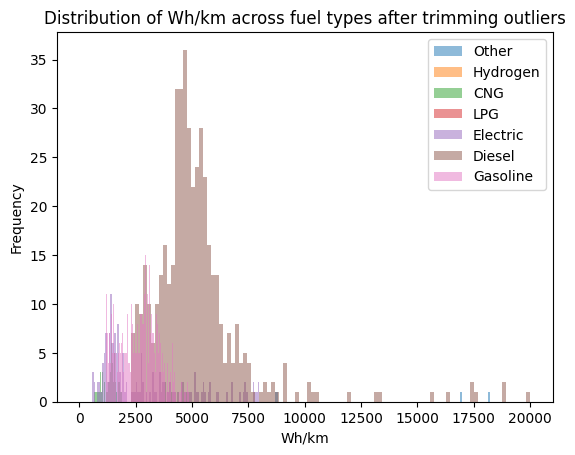

/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:130: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['All Fuels (km)'] = sum([df[f + ' (km)'].fillna(0) for f in new_fuel_types])
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors

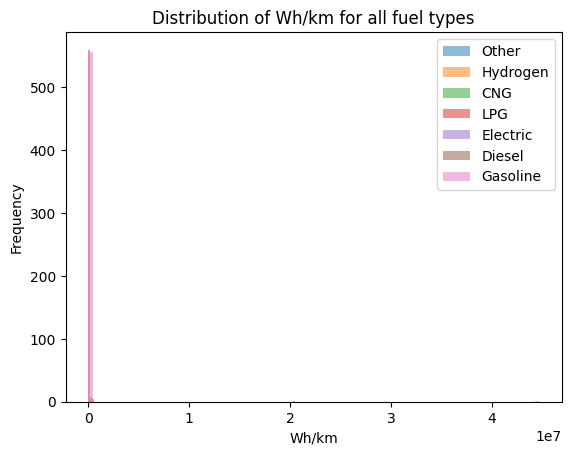

Len before trimming: 1135
Other description: count        7.000000
mean     21622.387016
std      34996.603553
min          1.336090
25%       2468.547918
50%      13290.767337
75%      16968.999466
max      99189.510919
Name: Other (Wh/km), dtype: float64
Other, trimming to [14.377623441341365, 50898.2758210559]
Hydrogen description: count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Hydrogen (Wh/km), dtype: float64
Hydrogen, trimming to [nan, nan]
CNG description: count     189.000000
mean     1539.404146
std       976.510300
min        65.760544
25%       976.349637
50%      1486.147208
75%      1777.435045
max      9827.693655
Name: CNG (Wh/km), dtype: float64
CNG, trimming to [624.6057848656676, 2382.1208197600085]
LPG description: count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: LPG (Wh/km), dtype: float64
LPG, trimming to [nan, nan]
Electric description: count 

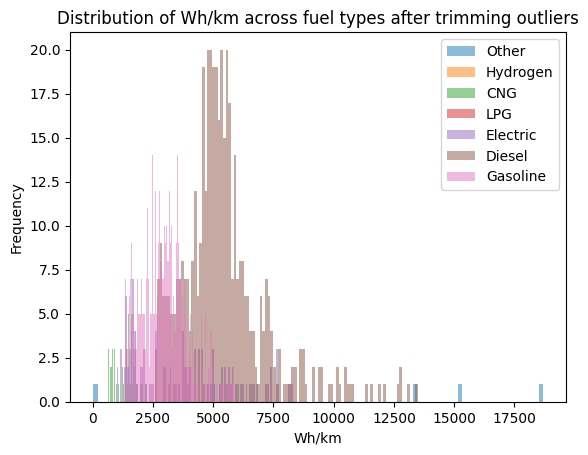

/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:130: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['All Fuels (km)'] = sum([df[f + ' (km)'].fillna(0) for f in new_fuel_types])
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors

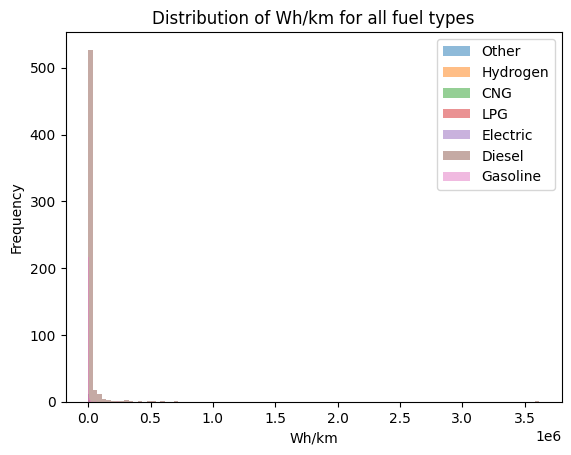

Len before trimming: 1117
Other description: count        7.000000
mean     17610.025022
std      23492.562841
min         26.886568
25%       3873.894707
50%      12687.824791
75%      17244.160933
max      68319.352517
Name: Other (Wh/km), dtype: float64
Other, trimming to [1977.9910214086744, 39928.57863572638]
Hydrogen description: count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Hydrogen (Wh/km), dtype: float64
Hydrogen, trimming to [nan, nan]
CNG description: count      180.000000
mean      1488.589444
std       1058.009680
min         57.471262
25%        970.060379
50%       1394.218866
75%       1688.983696
max      10108.939674
Name: CNG (Wh/km), dtype: float64
CNG, trimming to [724.7777265125522, 2117.2453936605516]
LPG description: count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: LPG (Wh/km), dtype: float64
LPG, trimming to [nan, nan]
Electric descriptio

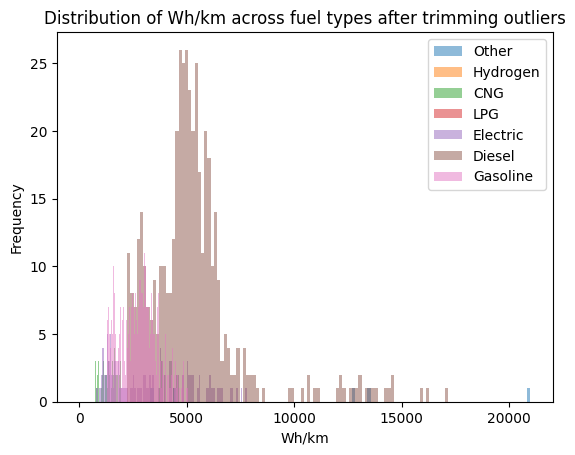

/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:130: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['All Fuels (km)'] = sum([df[f + ' (km)'].fillna(0) for f in new_fuel_types])
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors

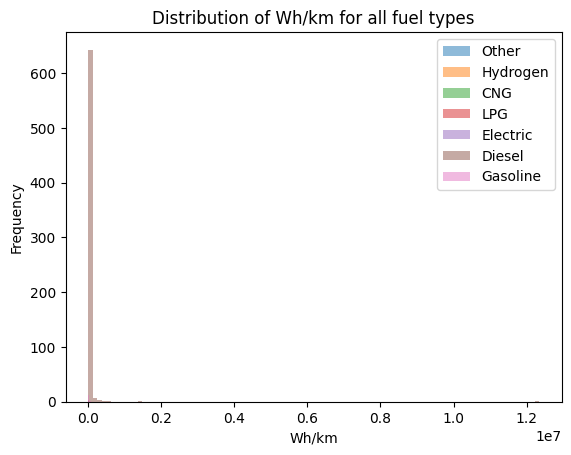

Len before trimming: 1125
Other description: count        8.000000
mean     11117.676049
std       9023.254185
min         68.469600
25%       4077.720666
50%      10304.535877
75%      16936.868847
max      25385.686979
Name: Other (Wh/km), dtype: float64
Other, trimming to [2528.13595680837, 20709.774757826148]
Hydrogen description: count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Hydrogen (Wh/km), dtype: float64
Hydrogen, trimming to [nan, nan]
CNG description: count      184.000000
mean      1548.163922
std       2010.413470
min        125.987913
25%        932.466483
50%       1389.663511
75%       1698.480211
max      27086.829363
Name: CNG (Wh/km), dtype: float64
CNG, trimming to [702.1155194806435, 2121.920529583033]
LPG description: count       35.000000
mean      3905.111618
std       2042.060565
min        193.694117
25%       2916.582277
50%       3433.177379
75%       4301.547717
max      12022.624873
Name: LPG (

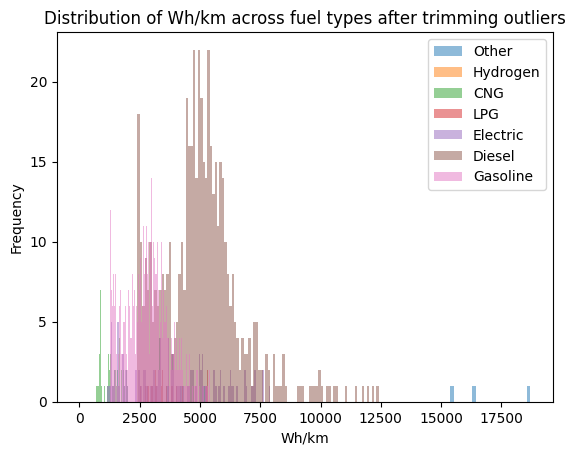

/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:130: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['All Fuels (km)'] = sum([df[f + ' (km)'].fillna(0) for f in new_fuel_types])
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_2209/3078468851.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [6]:
output = {}

def load_dataframe(urls, db_name, sheet_name=0):
    '''
    Return a dataframe for the given urls, database name and sheet name.
    '''
    if db_name + "_csv" in urls:
        return pd.read_csv(urls[db_name + "_csv"])
    elif db_name + "_xlsx" in urls:
        return pd.read_excel(urls[db_name + "_xlsx"], sheet_name=sheet_name)
    elif db_name + "_xlsm" in urls:
        with urlopen(urls[db_name + "_xlsm"]) as xlsm_file:
            return pd.read_excel(BytesIO(xlsm_file.read()), sheet_name=sheet_name)
    elif db_name + "_zip" in urls:
        with urlopen(urls[db_name + "_zip"]) as zip_file:
            with ZipFile(BytesIO(zip_file.read())) as zip_ref:
                with zip_ref.open(zip_ref.namelist()[0]) as xlsm_file:
                    return pd.read_excel(xlsm_file, sheet_name=sheet_name)
                

def agg_by_ntd_id_and_mode(df):
    # remove commas, convert to numeric, and sort
    df = df.replace({',': ''}, regex=True)
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.sort_values(by=['NTD ID', 'Mode'])
    # sum rows with the same NTD ID and Mode
    df = df.groupby(['NTD ID', 'Mode'], as_index=False).sum()
    return df


def make_fuel_energy_df(urls):
    df = load_dataframe(urls, 'fuel_energy', 'Fuel and Energy')
    cols = {
        'NTD ID': 'NTD ID',
        'Mode': 'Mode',
        # usage by fuel type
        'Diesel (gal)': 'Diesel (gal)',
        'Gasoline (gal)': 'Gasoline (gal)',
        'Liquefied Petroleum Gas (gal equivalent)': 'Liquefied Petroleum Gas (gal equivalent)',
        'Compressed Natural Gas (gal equivalent)': 'Compressed Natural Gas (gal equivalent)',
        'Bio-Diesel (gal)': 'Bio-Diesel (gal)',
        'Hydrogen (kg)': 'Hydrogen (kg)',
        'Other Fuel (gal/gal equivalent)': 'Other Fuel (gal/gal equivalent)',
        'Electric Propulsion (kwh)': 'Electric Propulsion (kWh)', # requires rename (kwh -> kWh)
        'Electric Battery (kwh)': 'Electric Battery (kWh)', # requires rename (kwh -> kWh)
        # miles by fuel type
        # require renames as older years did not include (miles) in the column name
        'Diesel': 'Diesel (miles)',
        'Gasoline': 'Gasoline (miles)',
        'Liquefied Petroleum Gas': 'Liquefied Petroleum Gas (miles)',
        'Compressed Natural Gas': 'Compressed Natural Gas (miles)',
        # 'Bio-Diesel': 'Bio-Diesel (miles)',
        'Hydrogen': 'Hydrogen (miles)',
        'Other Fuel': 'Other Fuel (miles)',
        'Electric Propulsion': 'Electric Propulsion (miles)',
        'Electric Battery': 'Electric Battery (miles)',
    }
    df = df.rename(columns=cols)

    # "Hydrogen" fuel type did not exist in older years
    # if these cols are missing, add them with all 0 values
    if 'Hydrogen (miles)' not in df.columns:
        df['Hydrogen (miles)'] = 0
    if 'Hydrogen (kg)' not in df.columns:
        df['Hydrogen (kg)'] = 0

    if 'UACE Code' not in df.columns:
        agency_info_df = load_dataframe(urls, 'agency_info')[['NTD ID', 'Primary UZA']]
        agency_info_df['UACE Code'] = agency_info_df['Primary UZA'].map(uza_to_uace)
        ntd_to_uace = agency_info_df.set_index("NTD ID")["UACE Code"].to_dict()
    else:
        ntd_to_uace = df.set_index("NTD ID")["UACE Code"].apply(lambda x: str(x).zfill(5)).to_dict()

    df = df[list(cols.values())]
    df = agg_by_ntd_id_and_mode(df)

    # add UACE Code and drop rows where it is missing
    df['UACE Code'] = df['NTD ID'].map(ntd_to_uace)
    df = df.dropna(subset=['UACE Code'])

    fuels = {
        "Gasoline": {"given_unit": "gal", "kwh_per_unit": emcmfu.KWH_PER_GAL_GASOLINE, "alias": "Gasoline"},
        "Diesel": {"given_unit": "gal", "kwh_per_unit": emcmfu.KWH_PER_GAL_DIESEL, "alias": "Diesel"},
        "Bio-Diesel": {"given_unit": "gal", "kwh_per_unit": emcmfu.KWH_PER_GAL_BIODIESEL, "alias": "Diesel"},
        "Liquefied Petroleum Gas": {"given_unit": "gal equivalent", "kwh_per_unit": emcmfu.KWH_PER_GAL_LPG, "alias": "LPG"},
        "Compressed Natural Gas": {"given_unit": "gal equivalent", "kwh_per_unit": emcmfu.KWH_PER_GAL_CNG, "alias": "CNG"},
        "Hydrogen": {"given_unit": "kg", "kwh_per_unit": emcmfu.KWH_PER_KG_HYDROGEN, "alias": "Hydrogen"},
        "Electric Propulsion": {"given_unit": "kWh", "kwh_per_unit": 1, "alias": "Electric"},
        "Electric Battery": {"given_unit": "kWh", "kwh_per_unit": 1, "alias": "Electric"},
        "Other Fuel": {"given_unit": "gal/gal equivalent", "kwh_per_unit": emcmfu.KWH_PER_GAL_OTHER, "alias": "Other"}
    }

    # add a column for total miles across all fuel types
    # and remove any rows where this is 0

    # for all fuel types, convert to km
    for fuel_type in fuels:
        if fuel_type == 'Bio-Diesel': continue # there is no Bio-Diesel (miles) column
        old_col_name = fuel_type + ' (miles)'
        new_col_name = fuels[fuel_type]['alias'] + ' (km)'
        if new_col_name not in df.columns:
            df[new_col_name] = df[old_col_name] / emcmfu.MI_PER_KM
        else:
            df[new_col_name] += df[old_col_name] / emcmfu.MI_PER_KM
    df = df.drop(columns=[fuel_type + ' (miles)' for fuel_type in fuels if fuel_type != 'Bio-Diesel'])

    # for all fuel types, convert to kWh
    get_old_col_name = lambda fuel_type: fuel_type + ' (' + fuels[fuel_type]['given_unit'] + ')'
    for fuel_type in fuels:
        old_col_name = get_old_col_name(fuel_type)
        new_col_name = fuels[fuel_type]['alias'] + ' (kWh)'
        if new_col_name not in df.columns:
            df[new_col_name] = df[old_col_name] * fuels[fuel_type]['kwh_per_unit']
        else:
            df[new_col_name] += df[old_col_name] * fuels[fuel_type]['kwh_per_unit']
    df = df.drop(columns=[get_old_col_name(f) for f in fuels])

    # now add a wh/km column for each fuel type
    new_fuel_types = list(set([fuels[f]['alias'] for f in fuels]))
    for fuel_type in new_fuel_types:
        df[f"{fuel_type} (Wh/km)"] = (df[f"{fuel_type} (kWh)"] * 1000 / df[f"{fuel_type} (km)"])
        # fill missing values with 0
        df[f"{fuel_type} (Wh/km)"] = df[f"{fuel_type} (Wh/km)"].fillna(0)
        # replace infinite values with 0
        df[f"{fuel_type} (Wh/km)"] = df[f"{fuel_type} (Wh/km)"].replace([float('inf'), float('-inf')], 0)

    # remove outliers based on Wh/km
    df = fuel_energy_df_without_outliers(df, new_fuel_types)

    df['All Fuels (km)'] = sum([df[f + ' (km)'].fillna(0) for f in new_fuel_types])
    df = df[df['All Fuels (km)'] != 0]

    return df


def make_service_df(urls):
    df = load_dataframe(urls, 'service', 'Annual Service Data By Mode')
    cols = {
        'NTD ID': 'NTD ID',
        'Mode': 'Mode',
        'Passenger Miles Traveled': 'Passenger Miles', # requires rename
        'Unlinked Passenger Trips (UPT)': 'Unlinked Passenger Trips', # requires rename
        'Actual Vehicle/Passenger Car Miles': 'Vehicle Miles', # requires rename
        'Train Miles': 'Train Miles'
    }
    df = df.rename(columns=cols)
    df = df[list(cols.values())]

    df = agg_by_ntd_id_and_mode(df)

    # convert miles columns to km
    miles_cols = ['Vehicle Miles', 'Train Miles', 'Passenger Miles']
    for col in miles_cols:
        new_col_name = col.replace('Miles', 'km')
        df[new_col_name] = df[col] / emcmfu.MI_PER_KM
    df = df.drop(columns=miles_cols)

    # remove rows that have "Passenger km" = 0 or "Vehicle km" = 0
    df = df[(df['Passenger km'] != 0) & (df['Vehicle km'] != 0)]

    # add "Average Passengers" column
    df['Average Passengers'] = df['Passenger km'] / df['Vehicle km']
    return df


for year, urls in ntd_urls.items():
    fuel_energy_df = make_fuel_energy_df(urls)
    service_df = make_service_df(urls)
    df = fuel_energy_df.merge(service_df, on=['NTD ID', 'Mode'])
    df = df.convert_dtypes()
    records = df.to_dict(orient='records')
    # remove NA values since they are not JSON serializable and just take up space
    records = [ { k: v for k, v in record.items() if v and v == v } for record in records ]
    output[year] = records

Dump output to a file called `ntd_data_by_year.py`

In [7]:
with open('../src/emcommon/metrics/footprint/ntd_data_by_year.py', 'w') as f:
  f.write(f"ntd_data = {json.dumps(output, indent=2)}\n"
          + f"uace_zip_maps = {json.dumps(uace_zip_maps, indent=2)}\n")

In [8]:
# Plots to investigate discrepancies in miles between "Fuel & Energy" and "Service" data

print('year: ' + str(year))
print(df.dtypes)
display(df)

df['All Fuels (miles) / Vehicle Miles'] = df['All Fuels (miles)'] / df['Vehicle Miles']
max_outliers = df.loc[df['All Fuels (miles) / Vehicle Miles'] > 5][['NTD ID', 'Mode', 'All Fuels (miles) / Vehicle Miles']]
print(f"Outliers where All Fuels (miles) / Vehicle Miles > 5: {len(max_outliers)}")
display(max_outliers)
min_outliers = df.loc[df['All Fuels (miles) / Vehicle Miles'] < 0.2][['NTD ID', 'Mode', 'All Fuels (miles) / Vehicle Miles']]
print(f"Outliers where All Fuels (miles) / Vehicle Miles < 0.2: {len(min_outliers)}")
display(min_outliers)

within_10_percent = df.loc[(df['All Fuels (miles) / Vehicle Miles'] < 1.1) & (df['All Fuels (miles) / Vehicle Miles'] > 0.9)]
print(f"Rows where All Fuels (miles) is within 10% of Vehicle Miles: {len(within_10_percent)}")
display(within_10_percent)

within_5_percent = df.loc[(df['All Fuels (miles) / Vehicle Miles'] < 1.05) & (df['All Fuels (miles) / Vehicle Miles'] > 0.95)]
print(f"Rows where All Fuels (miles) is within 5% of Vehicle Miles: {len(within_5_percent)}")
display(within_5_percent)

within_1_percent = df.loc[(df['All Fuels (miles) / Vehicle Miles'] < 1.01) & (df['All Fuels (miles) / Vehicle Miles'] > 0.99)]
print(f"Rows where All Fuels (miles) is within 1% of Vehicle Miles: {len(within_1_percent)}")
display(within_1_percent)

equal = df.loc[df['All Fuels (miles) / Vehicle Miles'] == 1]
print(f"Rows where All Fuels (miles) is equal to Vehicle Miles: {len(equal)}")
display(equal)

# scatter plot of All Fuels (miles) vs Vehicle Miles
plt.scatter(df['All Fuels (miles)'], df['Vehicle Miles'])
plt.title("All Fuels (miles) vs Vehicle Miles")
plt.suptitle(f"{year} NTD Data")
plt.xlabel("All Fuels (miles)")
plt.ylabel("Vehicle Miles")
plt.xlim(0, 1000000)
plt.ylim(0, 1000000)
plt.show()

# histogram of All Fuels (miles) / Vehicle Miles
plt.hist(df['All Fuels (miles) / Vehicle Miles'], bins=100, range=(0, 5))
plt.title("All Fuels (miles) / Vehicle Miles")
plt.suptitle(f"{year} NTD Data")
plt.xlabel("All Fuels (miles) / Vehicle Miles")
plt.ylabel("Frequency")
plt.show()

year: 2018
NTD ID                               Int64
Mode                        string[python]
UACE Code                   string[python]
Gasoline (km)                      Float64
Diesel (km)                        Float64
LPG (km)                           Float64
CNG (km)                           Float64
Hydrogen (km)                       object
Electric (km)                      Float64
Other (km)                         Float64
Gasoline (kWh)                     Float64
Diesel (kWh)                       Float64
LPG (kWh)                          Float64
CNG (kWh)                          Float64
Hydrogen (kWh)                      object
Electric (kWh)                     Float64
Other (kWh)                        Float64
Other (Wh/km)                      Float64
Hydrogen (Wh/km)                    object
CNG (Wh/km)                        Float64
LPG (Wh/km)                        Float64
Electric (Wh/km)                   Float64
Diesel (Wh/km)                     Float64


,NTD ID,Mode,UACE Code,Gasoline (km),Diesel (km),LPG (km),CNG (km),Hydrogen (km),Electric (km),Other (km),...,LPG (Wh/km),Electric (Wh/km),Diesel (Wh/km),Gasoline (Wh/km),All Fuels (km),Unlinked Passenger Trips,Vehicle km,Train km,Passenger km,Average Passengers
0,1,DR,80389,6693970.26897,<NA>,2853990.611084,<NA>,<NA>,<NA>,<NA>,...,3020.941937,<NA>,<NA>,2402.567946,9547960.880054,883312,15895044.989225,0.0,14227377.846729,0.895083
1,1,MB,80389,1742508.099026,69341993.752525,<NA>,<NA>,<NA>,245793.575819,<NA>,...,<NA>,1609.187704,5608.596357,2269.348419,71330295.427369,104261625,72113336.47692,0.0,814294233.235861,11.291867
2,1,SR,80389,<NA>,<NA>,<NA>,<NA>,<NA>,340489.015419,<NA>,...,<NA>,7193.045558,<NA>,<NA>,340489.015419,1685668,340489.015419,340489.015419,2987439.066194,8.773966
3,1,TB,80389,<NA>,<NA>,<NA>,<NA>,<NA>,5265136.287339,<NA>,...,<NA>,3833.078936,<NA>,<NA>,5265136.287339,17950742,5264870.745497,0.0,55309105.188366,10.505311
4,2,DR,83764,264619.687755,4335129.898241,<NA>,<NA>,<NA>,<NA>,27582.555349,...,<NA>,<NA>,2433.394988,3689.658953,4627332.141346,475326,4369085.457802,0.0,6827607.017386,1.562709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,90244,MB,90946,<NA>,<NA>,<NA>,876730.648839,<NA>,<NA>,74206.874798,...,<NA>,<NA>,<NA>,<NA>,950937.523637,288833,930617.940007,0.0,2042069.874519,2.194316
924,90299,CR,79498,<NA>,1344398.113205,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,7781.284771,<NA>,1344398.113205,636029,1241918.274268,622264.315522,26029817.934857,20.959365
925,99423,DR,51445,262620.881889,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,3090.631995,262620.881889,45144,295517.49277,0.0,408356.68224,1.381836
926,99423,MB,51445,<NA>,<NA>,<NA>,1276750.92658,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,1276750.92658,1504383,1225115.108365,0.0,5311845.902046,4.335793


KeyError: 'All Fuels (miles)'